<a href="https://colab.research.google.com/github/carinunez/Tareas_generativos/blob/hecmar_branch/Tarea_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3: Autoencoderes Variacionales

### MDS7203 Modelos Generativos Profundos

**Nombre:**
Carolina Nuñez y Hecmar Taucare

**Fecha de entrega:**

En esta tercera tarea se implementará un VAE para el dataset de juguete [`3d-shapes`](https://github.com/google-deepmind/3d-shapes). Los objetivos serán implementar una red neuronal acorde al dataset de entrenamiento, entrenar el VAE y estudiar las propiedades semánticas del espacio latente inducido.

Algunas instrucciones generales:

- Se pueden utilizar de manera libre herramientas como ChatGPT y Claude, entre otras.
- Para la entrega, no es necesario un informe, este archivo es suficiente.
- Se debe entregar el documento con todas las celdas ejecutadas.
- La tarea debe ser realizada en Google Colab.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Datos de entrenamiento

El dataset `3d-shapes` es un dataset artificial construido a partir de 6 factores latentes claramente definidos ([ver ejemplo](https://github.com/google-deepmind/3d-shapes/blob/master/3dshapes_loading_example.ipynb)):

```
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
```

Para la construcción de este dataset se consideraron distintos valores para cada factor latente. La cantidad de valores distintos para cada factor viene dada en el siguiente diccionario:

```
_NUM_VALUES_PER_FACTOR = {
    'floor_hue':   10,
    'wall_hue':    10,
    'object_hue':  10,
    'scale':       8,
    'shape':       4,
    'orientation': 15
    }
```

Lo que da un total de $10\times10\times10\times8\times4\times15=480\,000$ imágenes.

- ¿Qué define cada uno de estos factores latentes? ¿Cuáles son los distintos valores o rangos que pueden tomar estos factores latentes?
> **Respuesta:**
floor_hue representa el color del piso  y toma 10 valores separados linealmente entre 0 y 1
wall_hue corresponde al color de la pared, object_hue=color del objeto (ambos toman 10 valores), scale es el tamaño del objeto con 8 valores entre 0 y 1, shape es la forma del objeto tomando valores discretos enteros entre {0,1,2,3} y orientation (es el ángulo de rotación del objeto) tomando 15 valores equidistantes en el rango entre [-30°.30°]
- Considerando la naturaleza de cada factor latente, ¿qué distribuciones de probabilidad se podrían asociar a cada factor?
> **Respuesta:**
floor_hue toma valores equiespaciados entre 0 y 1, por lo que se podría asociar una distribución uniforme discreta sobre 10 valores, al igual que wall_he y object_hue. Mientras que scale sería una uniforme discreta de 8 valores (entre 0 y 1), por otro lado shape sería una distribución categórica uniforme tomando los valores {0,1,2,3} y orientation sería una uniforme discreta sobre 15 valores.
Las imágenes asociadas a este dataset están contenidas en el [siguiente archivo](https://console.cloud.google.com/storage/browser/3d-shapes;tab=objects?inv=1&invt=Abx13w&prefix=&forceOnObjectsSortingFiltering=false):

In [2]:
!gsutil -m cp gs://3d-shapes/3dshapes.h5 .

Copying gs://3d-shapes/3dshapes.h5...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1/1 files][255.2 MiB/255.2 MiB] 100% Done                                    
Operation completed over 1 objects/255.2 MiB.                                    


In [3]:
f = h5py.File('3dshapes.h5', 'r')
print("Claves del archivo:", list(f.keys()))

# Forma de las imágenes,etiquetas y formato
print("Tamaño de las imágenes:", f['images'].shape)
print("Tamaño de los labels:  ", f['labels'].shape)
print(type(f['labels']))

Claves del archivo: ['images', 'labels']
Tamaño de las imágenes: (480000, 64, 64, 3)
Tamaño de los labels:   (480000, 6)
<class 'h5py._hl.dataset.Dataset'>


### Clase para el dataset

- Implemente la clase `Shapes3D` utilizando el archivo descargado. Si tiene problemas de memoria RAM, puede fijar un parámetro `max_samples` para definir una cantidad máxima de muestras. En este caso, las imágenes seleccionadas para constituir el dataset deben ser elegidas de forma aleatoria sobre las $480\,000$ imágenes que contiene el dataset original.

In [4]:
class Shapes3D(Dataset):

    def __init__(self, filename, max_samples=None, seed=0):
        # nombre del archivo guardado
        self.filename = filename
        # se abre el archivo en el formato HDF5 para leer 'r'
        self.file = h5py.File(self.filename, 'r')

        # se guardan las imágenes y etiquetas
        self._images = self.file['images']
        self._labels = self.file['labels']

        # cantidad de imágenes en total
        self.total_samples = len(self._images)

        # índices se sacan de forma aleatoria para tomar muestra
        # replace = False es que sean distintos
        if max_samples is not None:
            rng = np.random.default_rng(seed)  # generador random con semilla
            self.indices = rng.choice(self.total_samples, size=max_samples, replace=False)
        else:
            self.indices = np.arange(self.total_samples)

    def __len__(self):
        return len(self.indices)  # cantidad de índices guardados

    def __getitem__(self, n):
        i = self.indices[n]  # se busca el índice

        # capturamos la imagen y su etiqueta asociada
        img = self._images[i].astype(np.float32) / 255.0  # normalización
        img = np.transpose(img, (2, 0, 1))  # cambia orden de ejes: alto, ancho, canales → canales, alto, ancho
        label = self._labels[i].astype(np.float32)
        return torch.tensor(img), torch.tensor(label)

Con la clase `Shapes3D` implementada, asumiendo que su constructor `__init__` recibe parámetros `filename` (nombre del archivo descargado) y `max_samples` (cantidad de muestras en el dataset), se puede instanciar el dataset y el respectivo dataloader.

- Defina valores para `batch_size` y `max_samples` que sean compatible con el hardware disponible.

In [5]:
# dataset = Shapes3D(filename='3dshapes.h5', max_samples=32)

In [6]:
batch_size = 12
max_samples = 32

dataset = Shapes3D(filename='3dshapes.h5', max_samples=max_samples)
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [7]:
# Ver el primer batch
for images, labels in dataloader:
    print("Tamaño del batch de imágenes:", images.shape)
    print("Tamaño del batch de labels:", labels.shape)
    break  # solo ver el primero

Tamaño del batch de imágenes: torch.Size([12, 3, 64, 64])
Tamaño del batch de labels: torch.Size([12, 6])


In [8]:
for batch_idx, (images, labels) in enumerate(dataloader):
    print(f"⭐ Batch {batch_idx + 1}")
    print("  Tamaño del batch de imágenes:", images.shape)
    print("  Tamaño del batch de labels:  ", labels.shape)

⭐ Batch 1
  Tamaño del batch de imágenes: torch.Size([12, 3, 64, 64])
  Tamaño del batch de labels:   torch.Size([12, 6])
⭐ Batch 2
  Tamaño del batch de imágenes: torch.Size([12, 3, 64, 64])
  Tamaño del batch de labels:   torch.Size([12, 6])
⭐ Batch 3
  Tamaño del batch de imágenes: torch.Size([8, 3, 64, 64])
  Tamaño del batch de labels:   torch.Size([8, 6])


- ¿Qué técnicas de data augmentation se podrían haber usado en este dataset? ¿Qué técnicas serían contraproducentes para el entrenamiento?
> **Respuesta:**
recortes de ciertas partes de la imagen aleatorios, desordenar la imagen para que el modelo aprendiera más texturas aunque sean figuras algo simples, dejar algunas partes en negro, agregar algo de ruido gaussiano.

Las que no servirian serian cambios de color, rotacion, escala, es decir todos los factores latentes que se buscan capturar con el modelo, ya que, estos existen y las imagenes creadas son una combinación de estos factores, por lo que esas transformaciones darían sobreajuste, ya que, sería aprender sobre lo mismo, y como algunos son factores latentes estan distribuidos linealmente sería aún más fácil que aprenda el modelo

### Visualización

La siguiente función auxiliar se usará para visualizar un batch de imágenes genérico:

In [9]:
def show_images(imgs, ncols=None):
    imgs = imgs.permute(0, 2, 3, 1).detach().cpu()
    n_images = imgs.shape[0]
    ncols = ncols or int(n_images**0.5)
    nrows = -(-n_images // ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for ax, img in zip(axes.flat, imgs):
        ax.imshow(img)
        ax.axis('off')
    for ax in axes.flat[n_images:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

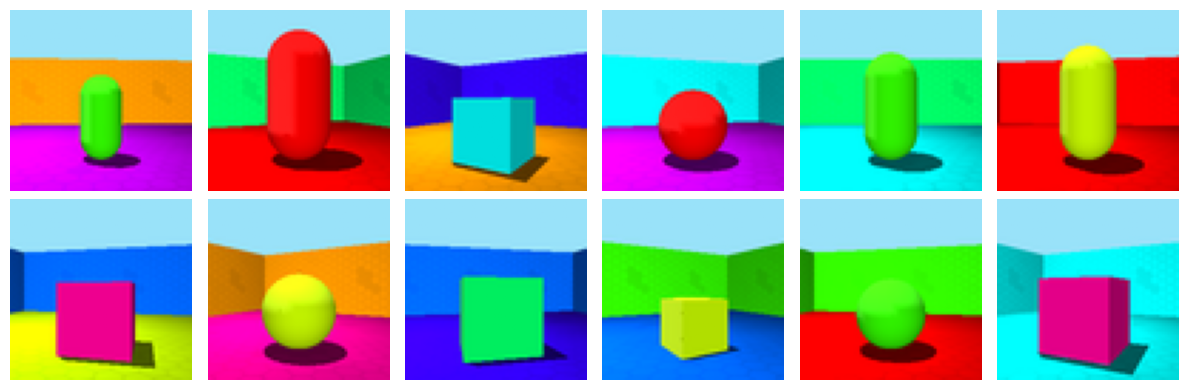

In [10]:
imgs, labels = next(iter(dataloader))
assert imgs.shape == (batch_size, 3, 64, 64)
assert labels.shape == (batch_size, 6)

show_images(imgs[:12], ncols=6)

## Red neuronal y entrenamiento

### Clase `VAE`

- Implemente la siguiente clase asociada a la red neuronal de un **VAE incondicional**. El método `forward` debe retornar el par $(\mu_\theta,\sigma_\theta)\in\mathbb{R}^L\times\mathbb{R}^L_{++}$ asociado al encoder y el tensor $r_\phi\in[0,1]^D$ asociado al decoder (revisar [implementación vista en clases](https://github.com/fernando-fetis/MDS7203/tree/main/Clases/Clase%2013/notebooks)). La red neuronal debe ser una red convolucional acorde a la complejidad del dataset, y puede usar cualquiera de las técnicas vistas durante el curso.

In [35]:
# Nos basamos en una arquitectura similar a la vista en clases, utilizando
# Conv2d porque estamos usando imag 2d de 3 canales, en lugar de datos como
# en el ejemplo de clases

class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU()
    )
    # Arquitectura: 3 canales de 64x64 -> 32 canales de 32x32 ->
    #               64 canales de 16x16 -> 128 canales de 8x8
    self.flatten = nn.Flatten()

    self.fc_mu = nn.Linear(128*8*8, latent_dim)
    self.fc_logvar = nn.Linear(128*8*8, latent_dim)

  def forward(self, x):
    x = self.conv(x)
    x = self.flatten(x) # (N,256)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu, logvar

In [12]:
# # Probar que el encoder está funcionando
# latent_dim = 8
# encoders = encoder_class(latent_dim)
# x = torch.randn(batch_size, 3, 64, 64)
# mean, std = encoders(x)  # q(z|x).

# assert mean.shape == (batch_size, latent_dim)
# assert std.shape == (batch_size, latent_dim)

In [36]:
class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    # Proyecta el vector latente a  un tensor de 128x8x8 para usarlo como entrada
    # de las capas conv
    # self.fc = nn.Sequential (

    # )

    self.dec = nn.Sequential(
        nn.Linear(latent_dim, 128*8*8),
        nn.ReLU(),
        nn.Unflatten(1, (128, 8, 8)),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
        # Utilizamos Sigmoid para obtener valores entre 0 y 1, ya que las
        # imágenes están normalizadas (ver arriba)
        nn.Sigmoid(),
    )

  def forward(self, z):
    # x = self.fc(z)
    # x = x.view(x.size(0), 128, 8, 8)
    return self.dec(z)

In [14]:
# decoder = Decoder(latent_dim)
# z = torch.randn(batch_size, latent_dim)
# mean = decoder(z)
# #
# assert mean.shape == (batch_size, 3, 64, 64)

In [37]:
class VAE(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
      # reparametrizamos z para que sea calculable

        std = torch.exp(0.5 * logvar)
        ep_noise = torch.randn_like(std)
        return mu + ep_noise * std # Agregamos ruido a la Gaussiana


    def forward(self, x):
        mu, logvar = self.encoder(x)

        z_noise = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z_noise)
        return (mu, logvar), x_recon # x_reconstruido

In [32]:
def extract_latents(model, dataloader):
    model.eval()
    all_z = []
    all_labels = []

    with torch.no_grad():
        for x, labels in dataloader:
            x = x.to(DEVICE)
            mu, _ = model.encoder(x)
            all_z.append(mu.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_z), torch.cat(all_labels)


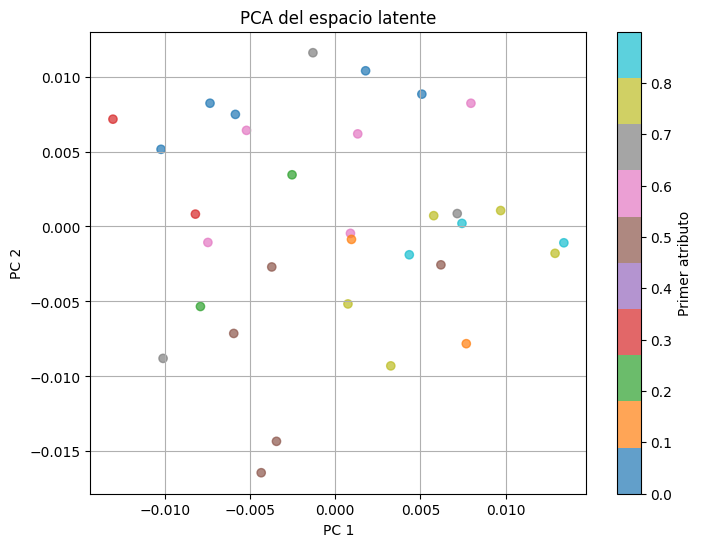

In [33]:
from sklearn.decomposition import PCA

z, labels = extract_latents(model, dataloader)
z_np = z.numpy()

# Reducir a 2D con PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_np)

# Visualizar
plt.figure(figsize=(8,6))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels[:, 0], cmap='tab10', alpha=0.7)
plt.colorbar(label="Primer atributo")
plt.title("PCA del espacio latente")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


Consideraciones:
En el notebook de la clase de usó MLP y transformaciones lineales, sin embargo como estaremos usando imágenes de figuras 3d, lo mejor es usar CNN porque:

- Invarianza translacional: Detecta características independientemente de su posición
- Compartición de parámetros: Muchísimos menos parámetros
- Jerarquía de características: Bordes → texturas → formas → objetos
- Preservación espacial: Mantiene relaciones geométricas cruciales para figuras 3D



### Loop de entrenamiento

Como se vio en clases, la ELBO de un VAE está compuesta por un término de reconstrucción y un término regularizador llamado prior matching:

\begin{equation}
\operatorname{ELBO}(x):=\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right] - \operatorname{{D}_{KL}}\left(q_\phi(z|x)\| p_\theta(z)\right)
\end{equation}

- ¿Qué diferencia esta función objetivo de la función objetivo usada en un autoencoder clásico? Dé una interpretación para ambos términos de la ELBO e indique cómo influyen en el entrenamiento de un VAE.
> **Respuesta:**


- La forma final del término de reconstrucción $\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right]$ depende de la distribución $p_\theta(x|z)$ elegida para el decoder. Indique qué distribución se asume implícitamente si el término de reconstrucción se calcula
  - Usando MSE (i.e., como la distancia $L^1$ entre la reconstrucción y la muestra original).
  > **Respuesta:**
  - Usando BCE (i.e., usando la entropía cruzada binaria entre la reconstrucción y la muestra original).
  > **Respuesta:**
  - Usando la distancia $L^1$ entre la reconstrucción y la muestra original.
  > **Respuesta:**

- Complete la función `train_vae` que permite entrenar un VAE sobre un dataset de imágenes. Esta función debe contener las siguientes características:
  - Permitir usar distintas métricas para el cálculo del término de reconstrucción. Esto se indica en el parámetro `reconstruction_metric`.
  - Permitir disentangled representations usando la técnica propuesta en $\beta$-VAE ([Higgins et al., 2017](https://openreview.net/forum?id=Sy2fzU9gl)). Esto se indica en el parámetro `beta`.

a

In [38]:
def train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs):
    model = model.to(DEVICE)
    model.train()

    total_steps = n_epochs * len(dataloader)
    global_bar = tqdm(total=total_steps, desc='Entrenamiento', position=0)

    reconstruction_log, prior_matching_log = [], []

    try:
        for epoch in range(1, n_epochs + 1):
            total_reconstruction, total_prior_matching = 0, 0

            for x, _ in dataloader:
                x = x.to(DEVICE)

                optimizer.zero_grad()

                # Encoder y decoder
                (encoder_mu, encoder_logvar), x_recon = model(x)
                encoder_std = torch.exp(0.5 * encoder_logvar)

                # --- KL divergencia entre N(mu, sigma^2) y N(0, I)
                prior_matching = -0.5 * torch.sum(
                    1 + encoder_logvar - encoder_mu.pow(2) - encoder_std.pow(2), dim=1
                )
                prior_matching = prior_matching.mean()

                # --- Reconstrucción (MSELoss ya es positiva)
                reconstruction = reconstruction_metric(x_recon, x)

                # --- Loss total como suma (ya que no es log-verosimilitud)
                loss = reconstruction + beta * prior_matching
                loss.backward()
                optimizer.step()

                # Logs
                total_reconstruction += reconstruction.item()
                total_prior_matching += prior_matching.item()

                global_bar.update(1)
                global_bar.set_postfix({
                    'época': epoch,
                    'reconstrucción': total_reconstruction / len(dataloader.dataset),
                    'prior matching': total_prior_matching / len(dataloader.dataset)
                })

            N = len(dataloader.dataset)
            reconstruction_log.append(total_reconstruction / N)
            prior_matching_log.append(total_prior_matching / N)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

    finally:
        global_bar.close()

        # --- Gráfico de evolución de términos
        fig, ax1 = plt.subplots(figsize=(10, 4))

        ax1.set_xlabel('Época')
        ax1.set_ylabel('', color='red')
        l1, = ax1.plot(reconstruction_log, label='Término de reconstrucción', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.set_ylabel('Escala término de reconstrucción')

        ax2 = ax1.twinx()
        ax2.set_ylabel('', color='blue')
        l2, = ax2.plot(prior_matching_log, label='Prior matching', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylabel('Escala prior matching')

        lines = [l1, l2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels)

        plt.title('Dinámica de entrenamiento')
        fig.tight_layout()
        plt.show()


In [18]:
def train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs):
    model = model.to(DEVICE)
    model.train()

    total_steps = n_epochs * len(dataloader)
    global_bar = tqdm(total=total_steps, desc='Entrenamiento', position=0)

    reconstruction_log, prior_matching_log = [], []

    try:
        for epoch in range(1, n_epochs + 1):
            total_reconstruction, total_prior_matching = 0, 0

            for x, _ in dataloader:
                x = x.to(DEVICE)

                # Entrenamiento -----------------------------------------------
                optimizer.zero_grad()

                # ELBO:
                (encoder_mu, encoder_logvar), x_recon = model(x)
                encoder_std = torch.exp(0.5 * encoder_logvar)

                # Prior matching (D_KL)
                prior_matching = -0.5 * torch.sum(
                    1 + encoder_logvar - encoder_mu.pow(2) - encoder_std.pow(2), dim=1
                )
                prior_matching = prior_matching.mean()

                # Reconstrucción
                reconstruction = reconstruction_metric(x_recon, x).mean()

                # ELBO y pérdida
                elbo = reconstruction - beta * prior_matching
                loss = -elbo.mean()

                loss.backward()
                optimizer.step()

                # Registro -----------------------------------------------------
                total_reconstruction += reconstruction.item()
                total_prior_matching += prior_matching.item()

                global_bar.update(1)
                global_bar.set_postfix({
                    'época': epoch,
                    'reconstrucción': total_reconstruction / len(dataloader.dataset),
                    'prior matching': total_prior_matching / len(dataloader.dataset)
                })

            N = len(dataloader.dataset)
            reconstruction_log.append(total_reconstruction / N)
            prior_matching_log.append(total_prior_matching / N)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

    finally:
        global_bar.close()

        # Gráfico --------------------------------------------------------------
        fig, ax1 = plt.subplots(figsize=(10, 4))

        ax1.set_xlabel('Época')
        ax1.set_ylabel('', color='red')
        l1, = ax1.plot(reconstruction_log, label='Término de reconstrucción', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.set_ylabel('Escala término de reconstrucción')

        ax2 = ax1.twinx()
        ax2.set_ylabel('', color='blue')
        l2, = ax2.plot(prior_matching_log, label='Prior matching', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylabel('Escala prior matching')

        lines = [l1, l2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels)

        plt.title('Dinámica de entrenamiento')
        fig.tight_layout()
        plt.show()


Con todo lo anterior bien definido, se puede entrenar el VAE sobre el dataset `Shapes3D`.

- Asigne valores a los hiperparámetros necesarios y entrene el modelo. Justifique su elección para los valores de `latent_dim`, `reconstruction_metric` y `beta`.

> **Respuesta:**
   Para asegurar la independencia de $q_ϕ$, se necesita un buen balance entre la preservación de la info y la capacidad de reconstrucción con $\beta>1$


In [ ]:
reconstruction = reconstruction_metric(x_recon, x)
loss = reconstruction + beta * prior_matching


Entrenamiento:   0%|          | 0/180 [00:00<?, ?it/s]

Entrenamiento interrumpido.


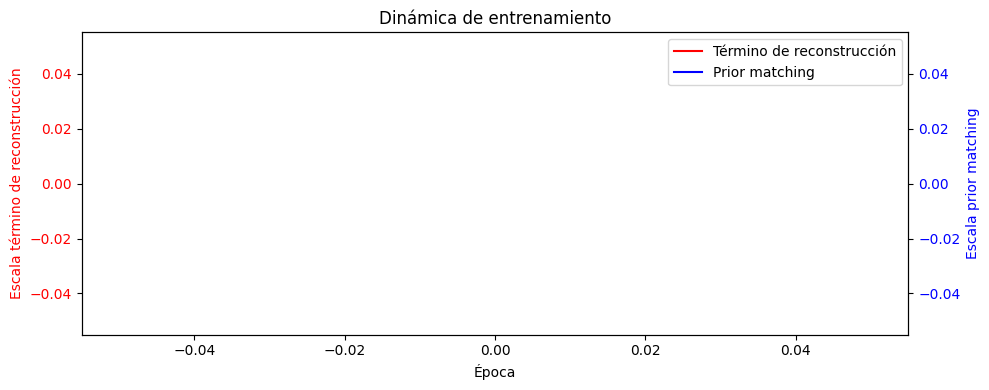

In [44]:
latent_dim = 132
reconstruction_metric = nn.MSELoss()
beta = 1.1
n_epochs = 60

model = VAE(latent_dim)
optimizer = torch.optim.Adam(model.parameters())#, lr=5e-5, betas=(0.9, 0.999))

train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs)

# primera que me dio

Entrenamiento:   0%|          | 0/24 [00:00<?, ?it/s]

logvar tensor([[-0.0302, -0.0105, -0.0296,  ..., -0.0051, -0.0115,  0.0467],
        [-0.0177, -0.0087, -0.0300,  ..., -0.0215, -0.0149,  0.0440],
        [-0.0315, -0.0109, -0.0222,  ..., -0.0124, -0.0295,  0.0521],
        ...,
        [-0.0219, -0.0002, -0.0194,  ..., -0.0157, -0.0188,  0.0373],
        [-0.0195, -0.0081, -0.0307,  ..., -0.0186, -0.0182,  0.0459],
        [-0.0370,  0.0001, -0.0209,  ...,  0.0072,  0.0067,  0.0365]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
std tensor([[0.9850, 0.9948, 0.9853,  ..., 0.9974, 0.9943, 1.0236],
        [0.9912, 0.9957, 0.9851,  ..., 0.9893, 0.9926, 1.0223],
        [0.9844, 0.9946, 0.9890,  ..., 0.9938, 0.9854, 1.0264],
        ...,
        [0.9891, 0.9999, 0.9904,  ..., 0.9922, 0.9906, 1.0188],
        [0.9903, 0.9960, 0.9847,  ..., 0.9908, 0.9909, 1.0232],
        [0.9817, 1.0001, 0.9896,  ..., 1.0036, 1.0034, 1.0184]],
       device='cuda:0', grad_fn=<ExpBackward0>)
mu tensor([[-0.0090, -0.0071,  0.0003,  ...,  0.0071, -0.01

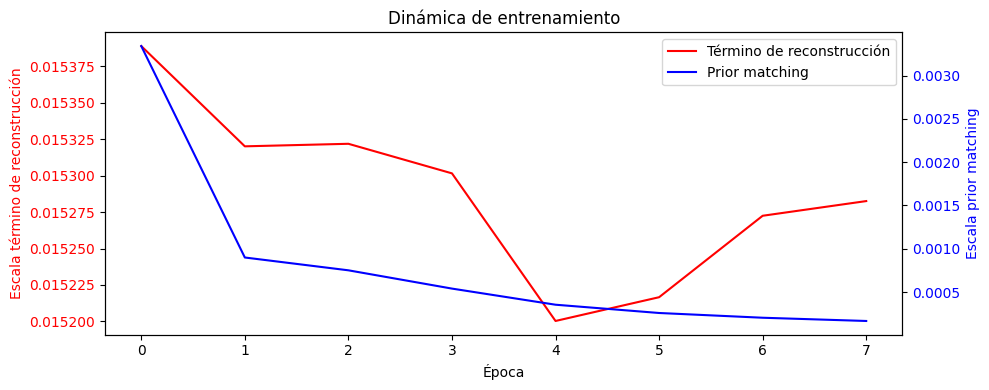

In [55]:
# 🔧 Hiperparámetros
latent_dim = 132
beta = 1              # Podés subirlo más adelante
n_epochs = 8
reconstruction_metric = nn.MSELoss()  # MSE estándar

# 🧠 Modelo VAE
model = VAE(latent_dim)

# ⚙️ Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# 🚂 Entrenamiento
def train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs):
    model = model.to(DEVICE)
    model.train()

    total_steps = n_epochs * len(dataloader)
    global_bar = tqdm(total=total_steps, desc='Entrenamiento', position=0)

    reconstruction_log, prior_matching_log = [], []

    try:
        for epoch in range(1, n_epochs + 1):
            total_reconstruction, total_prior_matching = 0, 0

            for x, _ in dataloader:
                x = x.to(DEVICE)

                optimizer.zero_grad()

                # Encoder y decoder
                (encoder_mu, encoder_logvar), x_recon = model(x)
                encoder_std = torch.exp(0.5 * encoder_logvar)
                print("logvar",encoder_logvar)
                print("std",encoder_std)
                print("mu",encoder_mu)

                # --- KL divergencia entre N(mu, sigma^2) y N(0, I)
                encoder_var = torch.exp(encoder_logvar)
                prior_matching = -0.5 * torch.sum(1 + encoder_logvar - encoder_mu.pow(2) - encoder_var, dim=1)
                prior_matching = prior_matching.mean()

                # --- Reconstrucción
                reconstruction = reconstruction_metric(x, x_recon)

                # --- Loss total
                loss = reconstruction +beta * prior_matching
                loss.backward()
                optimizer.step()

                # Logs
                total_reconstruction += reconstruction.item()
                total_prior_matching += prior_matching.item()

                global_bar.update(1)
                global_bar.set_postfix({
                    'época': epoch,
                    'reconstrucción': total_reconstruction / len(dataloader.dataset),
                    'prior matching': total_prior_matching / len(dataloader.dataset)
                })

            N = len(dataloader.dataset)
            reconstruction_log.append(total_reconstruction / N)
            prior_matching_log.append(total_prior_matching / N)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

    finally:
        global_bar.close()

        # --- Gráfico de evolución
        fig, ax1 = plt.subplots(figsize=(10, 4))

        ax1.set_xlabel('Época')
        ax1.set_ylabel('', color='red')
        l1, = ax1.plot(reconstruction_log, label='Término de reconstrucción', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.set_ylabel('Escala término de reconstrucción')

        ax2 = ax1.twinx()
        ax2.set_ylabel('', color='blue')
        l2, = ax2.plot(prior_matching_log, label='Prior matching', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylabel('Escala prior matching')

        lines = [l1, l2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels)

        plt.title('Dinámica de entrenamiento')
        fig.tight_layout()
        plt.show()

# 🏃‍♂️ Corre el entrenamiento
train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs)


Entrenamiento:   0%|          | 0/180 [00:00<?, ?it/s]

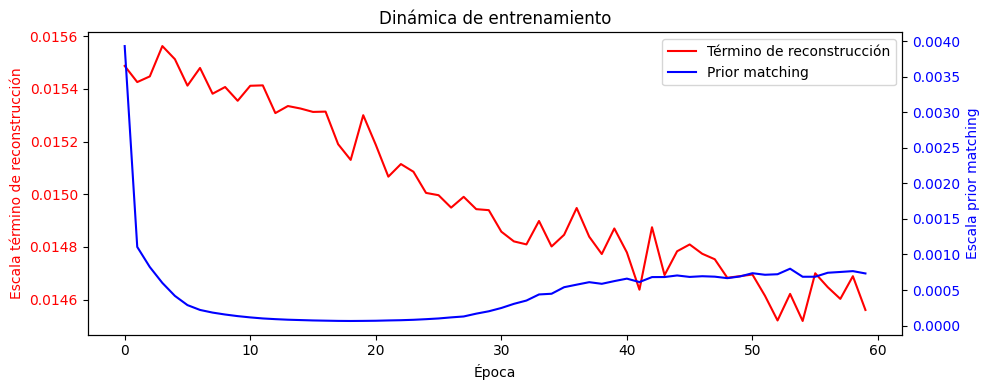

In [40]:
# 🔧 Hiperparámetros
latent_dim = 132
beta = 0.01               # Podés subirlo más adelante
n_epochs = 60
reconstruction_metric = nn.MSELoss()  # MSE estándar

# 🧠 Modelo VAE
model = VAE(latent_dim)

# ⚙️ Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# 🚂 Entrenamiento
def train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs):
    model = model.to(DEVICE)
    model.train()

    total_steps = n_epochs * len(dataloader)
    global_bar = tqdm(total=total_steps, desc='Entrenamiento', position=0)

    reconstruction_log, prior_matching_log = [], []

    try:
        for epoch in range(1, n_epochs + 1):
            total_reconstruction, total_prior_matching = 0, 0

            for x, _ in dataloader:
                x = x.to(DEVICE)

                optimizer.zero_grad()

                # Encoder y decoder
                (encoder_mu, encoder_logvar), x_recon = model(x)
                encoder_std = torch.exp(0.5 * encoder_logvar)

                # --- KL divergencia entre N(mu, sigma^2) y N(0, I)
                prior_matching = -0.5 * torch.sum(
                    1 + encoder_logvar - encoder_mu.pow(2) - encoder_std.pow(2), dim=1
                )
                prior_matching = prior_matching.mean()

                # --- Reconstrucción
                reconstruction = reconstruction_metric(x_recon, x)

                # --- Loss total
                loss = reconstruction + beta * prior_matching
                loss.backward()
                optimizer.step()

                # Logs
                total_reconstruction += reconstruction.item()
                total_prior_matching += prior_matching.item()

                global_bar.update(1)
                global_bar.set_postfix({
                    'época': epoch,
                    'reconstrucción': total_reconstruction / len(dataloader.dataset),
                    'prior matching': total_prior_matching / len(dataloader.dataset)
                })

            N = len(dataloader.dataset)
            reconstruction_log.append(total_reconstruction / N)
            prior_matching_log.append(total_prior_matching / N)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

    finally:
        global_bar.close()

        # --- Gráfico de evolución
        fig, ax1 = plt.subplots(figsize=(10, 4))

        ax1.set_xlabel('Época')
        ax1.set_ylabel('', color='red')
        l1, = ax1.plot(reconstruction_log, label='Término de reconstrucción', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.set_ylabel('Escala término de reconstrucción')

        ax2 = ax1.twinx()
        ax2.set_ylabel('', color='blue')
        l2, = ax2.plot(prior_matching_log, label='Prior matching', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylabel('Escala prior matching')

        lines = [l1, l2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels)

        plt.title('Dinámica de entrenamiento')
        fig.tight_layout()
        plt.show()

# 🏃‍♂️ Corre el entrenamiento
train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs)


In [52]:
import matplotlib.pyplot as plt

def reconstruct_and_inspect(model, dataloader, num_images=6):
    model.eval()
    with torch.no_grad():
        # Obtener batch
        imgs, _ = next(iter(dataloader))
        x = imgs[:num_images].to(DEVICE)

        # Pasar por el encoder
        mu, logvar = model.encoder(x)

        # Diagnóstico de los valores latentes
        std = torch.exp(0.5 * logvar)
        print("mu:      mean =", mu.mean().item(), ", min =", mu.min().item(), ", max =", mu.max().item())
        print("logvar:  mean =", logvar.mean().item(), ", min =", logvar.min().item(), ", max =", logvar.max().item())
        print("std:     mean =", std.mean().item(), ", min =", std.min().item(), ", max =", std.max().item())

        # Reparametrización
        z = mu + std * torch.randn_like(std)

        # Reconstrucción
        x_recon = model.decoder(z)

        # Mostrar imágenes
        all_imgs = torch.cat([x.cpu(), x_recon.cpu()], dim=0)  # originales arriba, reconstruidas abajo
        all_imgs = all_imgs.permute(0, 2, 3, 1)  # para que matplotlib las entienda

        fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
        for i in range(num_images):
            axes[0, i].imshow(all_imgs[i].numpy())
            axes[0, i].axis('off')
            axes[1, i].imshow(all_imgs[i + num_images].numpy())
            axes[1, i].axis('off')

        plt.suptitle("Fila 1: originales | Fila 2: reconstrucciones", fontsize=12)
        plt.tight_layout()
        plt.show()


In [53]:
def reconstruct_and_inspect(model, dataloader, num_images=6):
    model.eval()
    with torch.no_grad():
        # Obtener batch
        imgs, _ = next(iter(dataloader))
        x = imgs[:num_images].to(DEVICE)

        # Pasar por el encoder
        mu, logvar = model.encoder(x)

        # Diagnóstico de los valores latentes
        std = torch.exp(0.5 * logvar)
        print("mu:      mean =", mu.mean().item(), ", min =", mu.min().item(), ", max =", mu.max().item())
        print("logvar:  mean =", logvar.mean().item(), ", min =", logvar.min().item(), ", max =", logvar.max().item())
        print("std:     mean =", std.mean().item(), ", min =", std.min().item(), ", max =", std.max().item())

        # Reparametrización
        z = mu + std * torch.randn_like(std)

        # Reconstrucción
        x_recon = model.decoder(z)

        # Visualización
        show_images(torch.cat([x.cpu(), x_recon.cpu()], dim=0), ncols=num_images)


mu: 5.5225566029548645e-05 std: 1.0000064373016357
mu: 5.5225566029548645e-05 std: 1.0000064373016357


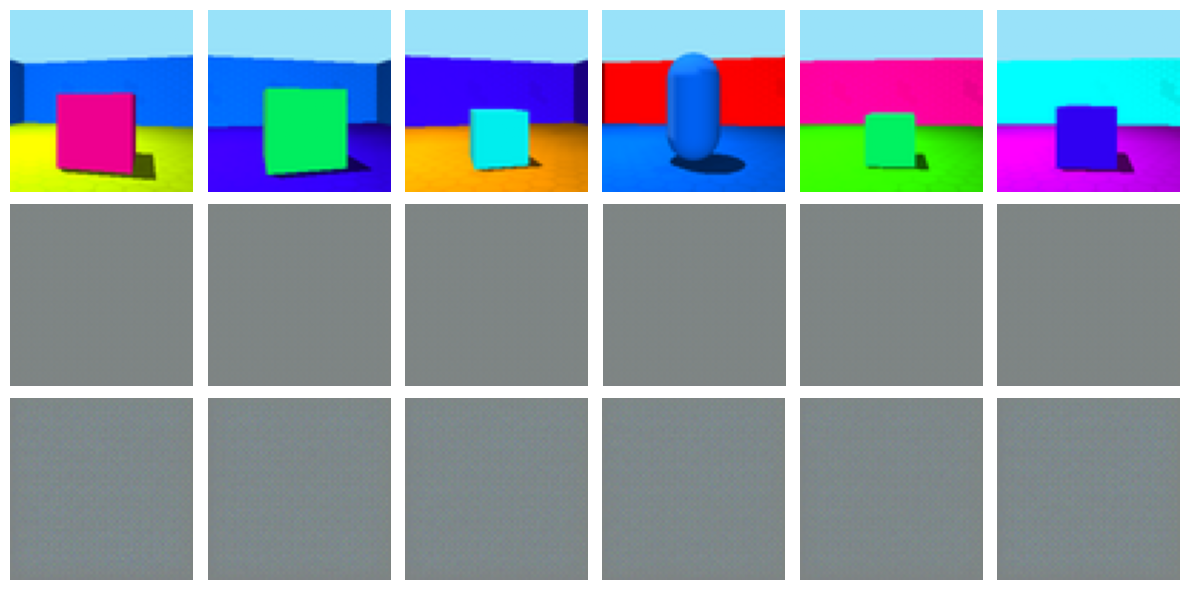

In [47]:
# 🔁 Obtener un batch de imágenes
imgs, _ = next(iter(dataloader))
x_original = imgs[:6].to(DEVICE)

# 🔍 Función de reconstrucción (determinista o estocástica)
def reconstruction(x, model, deterministic=True, noise_scale=1.0):
    model.eval()
    with torch.no_grad():
        # Obtener media y logvar del encoder
        mu, logvar = model.encoder(x)

        # Verificar valores del espacio latente (opcional para debug)
        print('mu:', mu.mean().item(), 'std:', torch.exp(0.5 * logvar).mean().item())

        # Reparametrización: z = mu + std * eps, o solo mu si es determinista
        if deterministic:
            z = mu
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std) * noise_scale
            z = mu + std * eps

        # Reconstrucción
        x_recon = model.decoder(z)
    return x_recon

# 🧱 Reconstrucción determinista (sin ruido)
x_reconstruction_det = reconstruction(x_original, model, deterministic=True)

# 🎲 Reconstrucción estocástica (con muestreo)
x_reconstruction_sto = reconstruction(x_original, model, deterministic=False, noise_scale=1.0)

# 📊 Visualizar: original (arriba), determinista (medio), estocástica (abajo)
show_images(torch.cat([x_original, x_reconstruction_det, x_reconstruction_sto], dim=0),
            ncols=len(x_original))



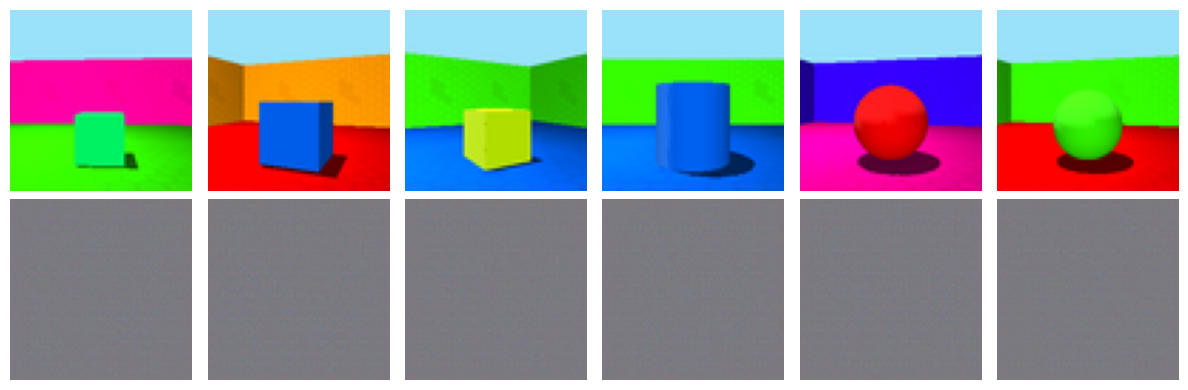

In [56]:
# 🔍 Visualización de reconstrucciones
imgs, _ = next(iter(dataloader))
x_original = imgs[:6].to(DEVICE)

def reconstruction(x, model):
    # El encoder devuelve media y logvar (no std)
    z_mean, z_logvar = model.encoder(x)

    # Aplicamos reparametrización correctamente
    z_std = torch.exp(0.5 * z_logvar)
    z = z_mean + z_std * torch.randn_like(z_mean)

    # Decodificamos
    x_dec = model.decoder(z)
    return x_dec

# Obtenemos reconstrucciones y visualizamos
x_reconstruction = reconstruction(x_original, model)
show_images(torch.cat([x_original, x_reconstruction], dim=0), ncols=len(x_original))


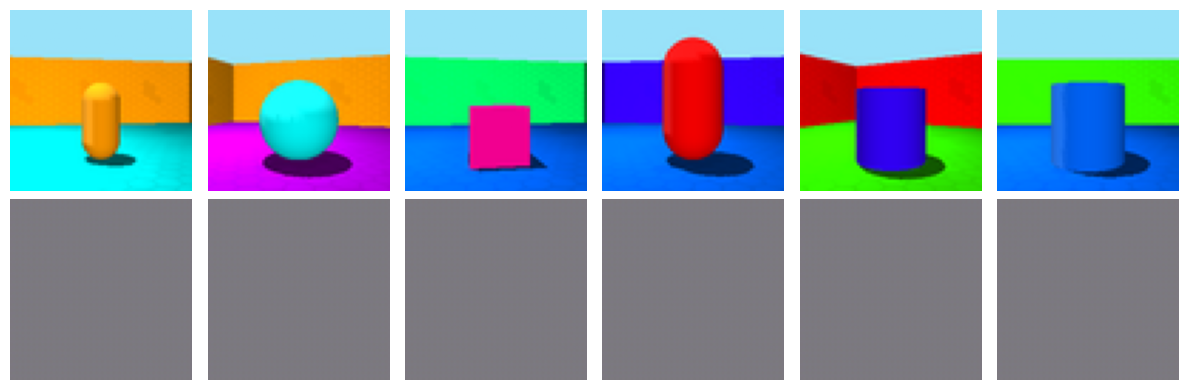

In [57]:
# Visualización de reconstrucciones
imgs, _ = next(iter(dataloader))
x_original = imgs[:6].to(DEVICE)

def reconstruction(x, model):
    z_mean, z_std = model.encoder(x)
    z = z_mean + z_std * torch.randn_like(z_mean)
    x_dec = model.decoder(z)
    return x_dec

x_reconstruction = reconstruction(x_original, model)
show_images(torch.cat([x_original, x_reconstruction], dim=0), ncols=len(x_original))


# INTENTO DE QUE CORRA

In [59]:
def generate_from_prior(model, n_samples=6):
    model.eval()
    with torch.no_grad():
        # 1. Crear vectores z ~ N(0, I)
        z = torch.randn(n_samples, model.latent_dim).to(DEVICE)

        # 2. Generar imágenes con el decoder
        x_gen = model.decoder(z)
    return x_gen


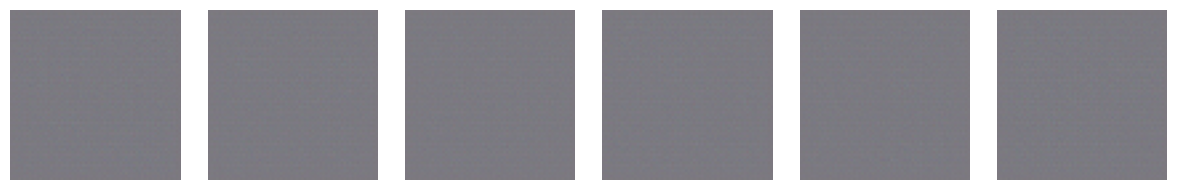

In [60]:
# 🔁 Generar imágenes nuevas desde el prior
generated_imgs = generate_from_prior(model, n_samples=6)

# 👁️ Mostrar imágenes generadas
show_images(generated_imgs, ncols=6)


#CODIGO NORMAL


## Tareas de generación

En esta última parte se pide implementar algunas funciones simples para evaluar el entrenamiento del VAE.

### Reconstrucción

- Implemente la función `reconstruction` que retorne la reconstrucción que realiza el VAE sobre una imagen.

In [61]:
def reconstruction(x, model):
  z_mean, z_std = model.encoder(x)
  z = z_mean # + z_std * torch.randn_like(z_mean)
  x_mean = model.decoder(z)
  x_dec = x_mean # + model.decoder_std * torch.randn_like(x_mean)
  return x_dec


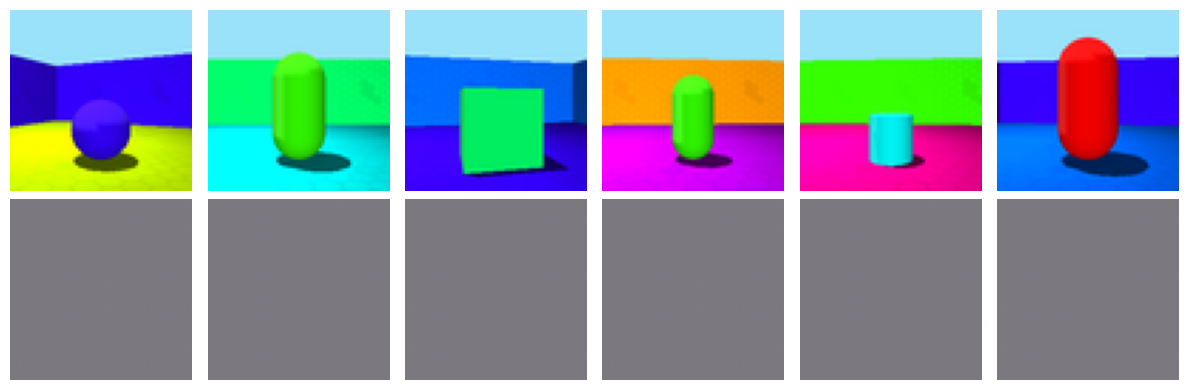

In [62]:
imgs, _ = next(iter(dataloader))

x_original = imgs[:6].to(DEVICE)
x_reconstruction = reconstruction(x_original, model)

show_images(torch.cat([x_original, x_reconstruction], dim=0), ncols=len(x_original))

### Generación de nuevas muestras


- Implemente la función `generate_samples` que genere muestras nuevas a partir del VAE.

In [22]:
def generate_samples(model, n_samples):
    ...

In [23]:
samples = generate_samples(model, n_samples=16)
show_images(samples)

AttributeError: 'NoneType' object has no attribute 'permute'

### Interpolación

El objetivo de esta pregunta es ver la diferencia entre una interpolación en el espacio de pixeles y el espacio latente inducido por el VAE.

#### Interpolación en el espacio de pixeles

- Implemente la función `interpolate_pixels` que interpole linealmente 2 imágenes. Notar que esta función no hace uso del VAE.

In [ ]:
def interpolate_pixels(x1, x2, steps=8):
    ...

In [ ]:
imgs, _ = next(iter(dataloader))

x1, x2 = imgs[0:2]
pixel_interpolation = interpolate_pixels(x1, x2, steps=8)

show_images(pixel_interpolation, ncols=len(pixel_interpolation))

#### Interpolación en el espacio latente

- Implemente la función `interpolate_latents` que interpole 2 imágenes en el espacio latente del VAE entrenado.

In [ ]:
def interpolate_latents(x1, x2, model, steps=8):
    ...

In [ ]:
imgs, _ = next(iter(dataloader))

# Se interpolan las mismas imágenes usadas en interpolate_pixels:
pixel_interpolation = interpolate_latents(x1, x2, model)

show_images(pixel_interpolation, ncols=len(pixel_interpolation))

### Aritmética en el espacio latente

El objetivo de esta pregunta es realizar aritmética de atributos, donde los atributos, en este caso, vienen dados en la lista `_FACTORS_IN_ORDER` definida al comienzo.

Recordar que, para un atributo dado, se puede calcular un centroide de dicho atributo, $z_{\text{atributo}}\in\mathbb{R}^L$, promediando representaciones latentes de muestras que posean dicho atributo. Con esto, restando los centroides de dos atributos diferentes se obtiene un vector latente director, $z_{\text{director}}\in\mathbb{R}^L$, el cual puede usarse para modificar atributos de una muestra $x\in\mathbb{R}^D$ mediante $x_\lambda = \text{decoder}(\text{encoder}(x)+\lambda z_\text{director})$, donde $\lambda>0$ es un parámetro de traslación.

- Implemente la función `attribute_arithmetic`, la cual recibe 2 diccionarios (`source_attributes` y `target_attributes`) con los atributos que se usarán para definir el vector director. Este vector debe ser aplicado a una imagen dada (`test_img`) usando los ponderadores definidos en la lista `ponderators`.

In [ ]:
def attribute_arithmetic(model, dataset, source_attributes, target_attributes, test_img, ponderators):
    ...

In [ ]:
# Imagen de prueba:
test_img, test_label = dataset[2]
ponderators = torch.linspace(0, 1, 8).tolist()

# Transformar forma original (cubo) -> esfera:
source_attributes = {'shape': test_label[4]}
target_attributes = {'shape': 2}

displaced_img = attribute_arithmetic(model, dataset, source_attributes, target_attributes, test_img, ponderators)

show_images(displaced_img, ncols=len(displaced_img))